# Line of Sight shift inspector
@author: Max Felius

The purpose of this notebook is to investigate the shift of the sinkhole pattern when the displacements are converted to the line of sight direction. 

## Roadmap
- define mogi model
- define spatial parameters
- calculate displacement parameters
- define function to mark the center
- convert displacement parameters to LOS
- find the new center of the los pattern
- calculate the shift distance
- define routine to calculate shift distance for a range of incidence angels

In [32]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Mogi Mode
Assumptions
- Isotropic elastic half space (Poisson's ratio $\nu$; Shear mdoulus $\mu$)
- $\alpha$ << d (i.e. spherical point source)
- Incompressible magma

$$
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix}
= \alpha^3 \Delta P \frac{(1-\nu)}{\mu}
\begin{pmatrix}
x/R^3 \\
y/R^3 \\
z/R^3
\end{pmatrix}
= \Delta V \frac{(1-\nu)}{\pi}
\begin{pmatrix}
x/R^3 \\
y/R^3 \\
z/R^3
\end{pmatrix}
$$


Source: http://indico.ictp.it/event/a08176/session/82/contribution/62/material/0/0.pdf <br>
https://academic.oup.com/gji/article/146/1/181/552369 (Fialko, Y. et al. (2001)) -> not implemented

Poissons' ratio ($\nu$) in Limburg: https://www.sciencedirect.com/science/article/abs/pii/S0013795202002065

$u$, $v$ and $w$ are the displacements in $(x,y,z)$ direction.

## How does a sinkhole cavity relate to the changing volume in the mogi model?

Within the theory of sinkhole evolution, the roof falls into the cavity when the cavity becomes too large for the roof to carry. When the roof collapses into the cavity, the materials will get washed away with sufficient time. Therefore, we assume that the volume change, as used in the Mogi model, is related to the amount of roof collapsed into the cavity. Since, the materials will be washed away over time, the overall volume of the cavity will stay the same.

In [2]:
'''
- define Mogi Model
- define spatial parameters
- calculate displacement parameters
'''
def mogi(dV,v,x,y,z,x0,y0,z0):
    r = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
    return dV * ((1-v)/np.pi) * np.array([(x-x0)/r**3,(y-y0)/r**3,(z-z0)/r**3])

# Setting up the volume parameters
w = 1 #[m], width of the cavity
H = 10 #[m], depth/height of the cavity
draw = 35 * (np.pi/180) #[rad], angle of draw
M = 1 #[m], cavity height
V = M * np.pi*(w/2)**2# [m3], The amount of roof that collapses into the cavity and gets washed away.

print(f'M={M}, w={w}, V={V}')

poisson = 0.3 #Poisson's ratio

# Setting up the grid parameters
# number of points
n = 200

#range of the model
x_range = 50
y_range = 50

#location of the source
x0 = 0
y0 = 0
z0 = -H-(M/2)

x = np.linspace(-x_range/2,x_range/2,n)
y = np.linspace(-y_range/2,y_range/2,n)
zv = np.zeros((n,n)) # surface is only important

xv, yv = np.meshgrid(x, y)
ds = np.abs(x[1]-x[0])

M=1, w=1, V=0.7853981633974483


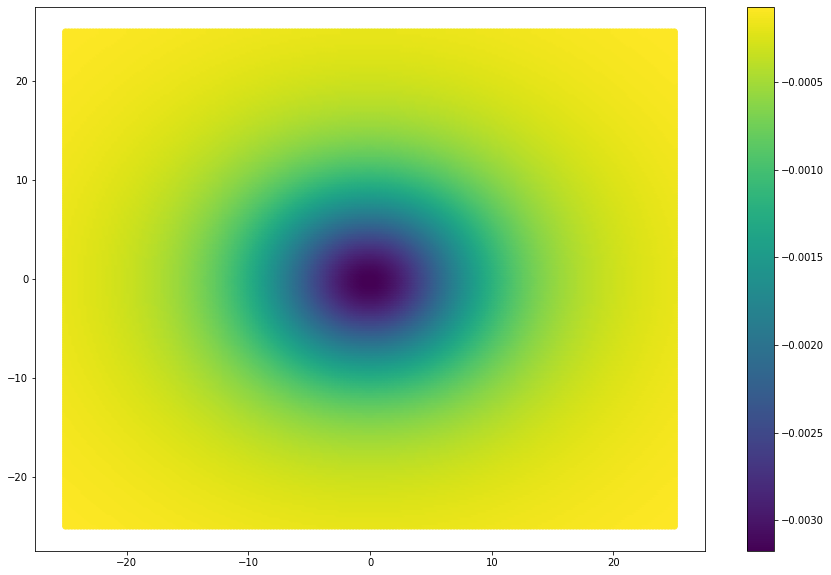

In [4]:
#calculating displacements
de, dn, du = mogi(-V,poisson,xv,yv,zv,x0,y0,z0)

#update points
xv = xv + de
yv = yv + dn
zv = zv + du

#plot intermediate results
fig_mogi, ax_mogi = plt.subplots(figsize=(15,10))

h = ax_mogi.scatter(xv,yv,c=zv)#,vmin=-0.01,vmax=0)
fig_mogi.colorbar(h, ax=ax_mogi);

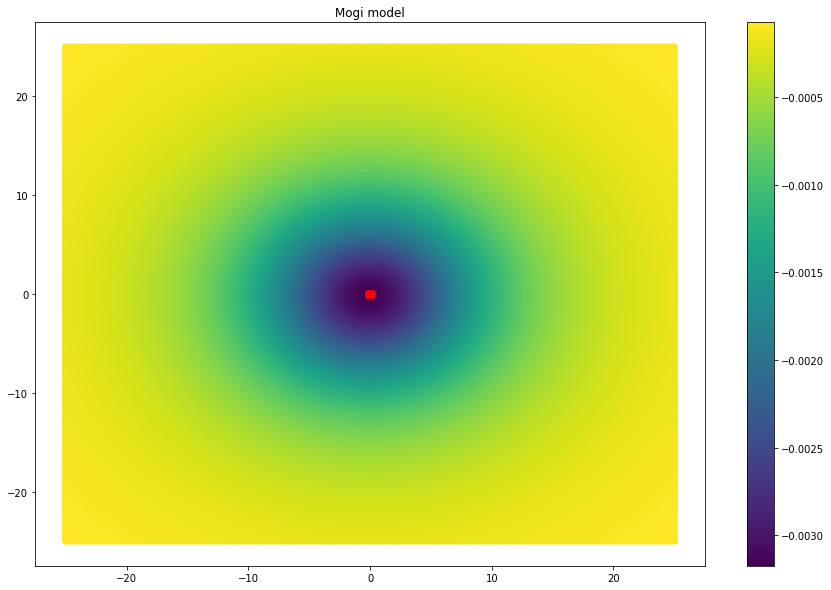

In [20]:
'''
- define function to mark the center
-> can use the minimum function?
'''
row_idx, col_idx = np.where(zv==np.min(zv))

#plot intermediate results
fig_mogi, ax_mogi = plt.subplots(figsize=(15,10))

h = ax_mogi.scatter(xv,yv,c=zv)
fig_mogi.colorbar(h, ax=ax_mogi)

ax_mogi.scatter(xv[row_idx,col_idx],yv[row_idx,col_idx],c='r')

ax_mogi.set_title('Mogi model');

In [16]:
'''
Convert displacement parameters to los
'''
#defining the deformation vector dgeo
def LOS_conversion(de,dn,du,los_angle,heading):    
#     de = xhdisp(x,x0,y,y0,R,H)
#     dn = yhdisp(x,x0,y,y0,R,H)
#     du = zg(x,x0,y,y0,R)    
    dgeo = np.array([de,dn,du])
    
    #incidence angle
    theta = np.deg2rad(los_angle)
    alpha = np.deg2rad(heading)
    
    #projection vector
    p = np.array([-np.sin(theta)*np.cos(alpha),np.sin(theta)*np.sin(alpha),np.cos(theta)])
    
    nx, ny = de.shape
    output = np.zeros((ny,nx))

    for i in range(ny):
        for j in range(nx):
            output[j,i] = p.T @ dgeo[:,j,i]
    return output

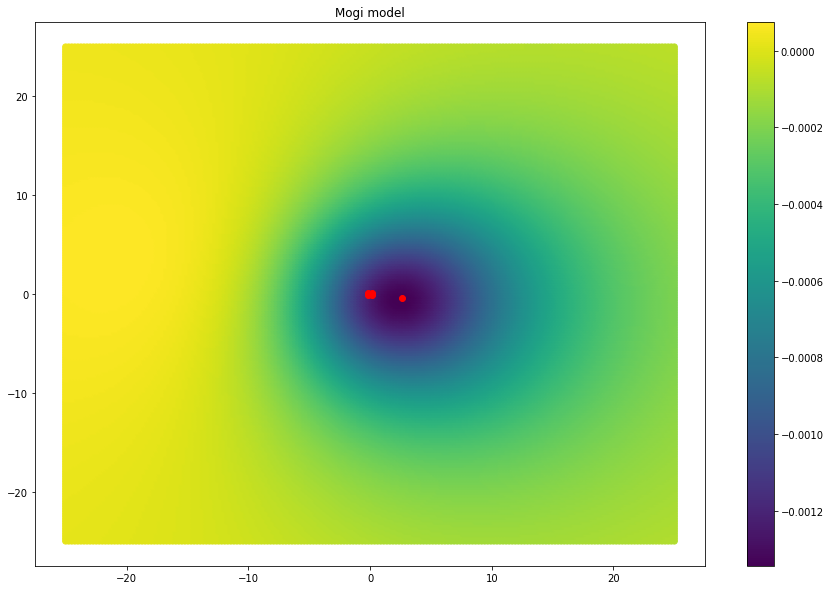

In [21]:
'''
- find the los pattern
'''
los_angle = 40 #[degrees]
heading = 190 #[degrees]

z_los = LOS_conversion(de,dn,du,los_angle,heading)

row_idx_los, col_idx_los = np.where(z_los==np.min(z_los))

#plot intermediate results
fig_mogi, ax_mogi = plt.subplots(figsize=(15,10))

h = ax_mogi.scatter(xv,yv,c=z_los)#,vmin=-0.01,vmax=0)
fig_mogi.colorbar(h, ax=ax_mogi)

ax_mogi.scatter(xv[row_idx,col_idx],yv[row_idx,col_idx],c='r')
ax_mogi.scatter(xv[row_idx_los,col_idx_los],yv[row_idx_los,col_idx_los],c='r')

ax_mogi.set_title('Mogi model');

In [26]:
'''
- Calculate the shift distance
'''
# x, y position of the mogi model
x_mogi = np.sum(xv[row_idx,col_idx])
y_mogi = np.sum(yv[row_idx,col_idx])

# x, y position in the line of sight
x_los = np.sum(xv[row_idx_los,col_idx_los])
y_los = np.sum(yv[row_idx_los,col_idx_los])

r = np.sqrt((x_mogi-x_los)**2 + (y_mogi-y_los)**2)

print(r)

2.664241494056032


In [68]:
def plot_test(z_in,angle):
    
    #plot intermediate results
    row_idx_los, col_idx_los = np.where(z_in==np.min(z_in))
    fig_mogi, ax_mogi = plt.subplots(figsize=(15,10))

    h = ax_mogi.scatter(xv,yv,c=z_in,vmin=-0.0016,vmax=0)
    fig_mogi.colorbar(h, ax=ax_mogi)

    ax_mogi.scatter(xv[row_idx,col_idx],yv[row_idx,col_idx],c='r')
    ax_mogi.scatter(xv[row_idx_los,col_idx_los],yv[row_idx_los,col_idx_los],c='r')

    ax_mogi.set_title('Mogi model. Incidence angle: {:.02f} $^o$. Heading 190 $^o$.'.format(angle));
    ax_mogi.set_xlabel('Distance East [m]')
    ax_mogi.set_ylabel('Distance North [m]')
    
    fig_mogi.savefig(f'images/shift_los_mogi_theta{angle}.png')
    
    plt.close('all')

Calculating: 100%|██████████| 30/30 [00:48<00:00,  1.63s/it]
No handles with labels found to put in legend.


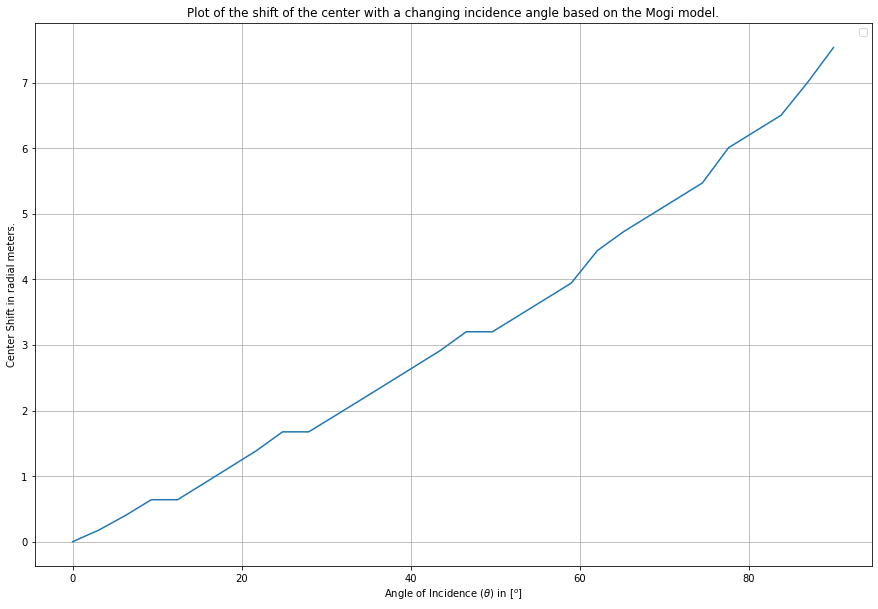

In [70]:
'''
- define routine to calculate shift distance for a range of incidence angels
'''
n = 30
heading = 190 #[degrees]

los_angle_range = np.linspace(0,90,n)
row_idx, col_idx = np.where(zv==np.min(zv))

# x, y position of the mogi model - center
x_mogi = np.sum(xv[row_idx,col_idx])
y_mogi = np.sum(yv[row_idx,col_idx])

%matplotlib inline

mogi_shift = []
for angle in tqdm(los_angle_range,'Calculating: '):
    z_los = LOS_conversion(de,dn,du,angle,heading)
    row_idx_los, col_idx_los = np.where(z_los==np.min(z_los))
    
    plot_test(z_los,angle)
    
    # x, y position in the line of sight
    x_los = np.sum(xv[row_idx_los,col_idx_los])
    y_los = np.sum(yv[row_idx_los,col_idx_los])
    
    r = np.sqrt((x_mogi-x_los)**2 + (y_mogi-y_los)**2)
    mogi_shift.append(r)

    
mogi_shift = np.array(mogi_shift)


#plot the results
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(los_angle_range,mogi_shift)

ax.set_title('Plot of the shift of the center with a changing incidence angle based on the Mogi model.')
ax.set_ylabel('Center Shift in radial meters.')
ax.set_xlabel('Angle of Incidence ($\\theta$) in [$^o$]')
ax.legend()
ax.grid(True);

No handles with labels found to put in legend.


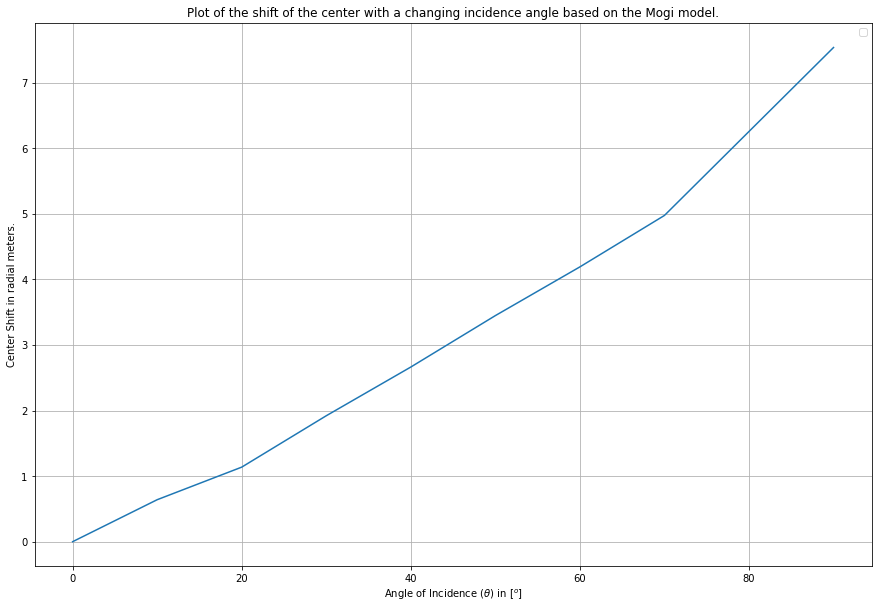

In [60]:
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(los_angle_range,mogi_shift)


ax.set_title('Plot of the shift of the center with a changing incidence angle based on the Mogi model.')
ax.set_ylabel('Center Shift in radial meters.')
ax.set_xlabel('Angle of Incidence ($\\theta$) in [$^o$]')
ax.legend()
ax.grid(True);

No handles with labels found to put in legend.


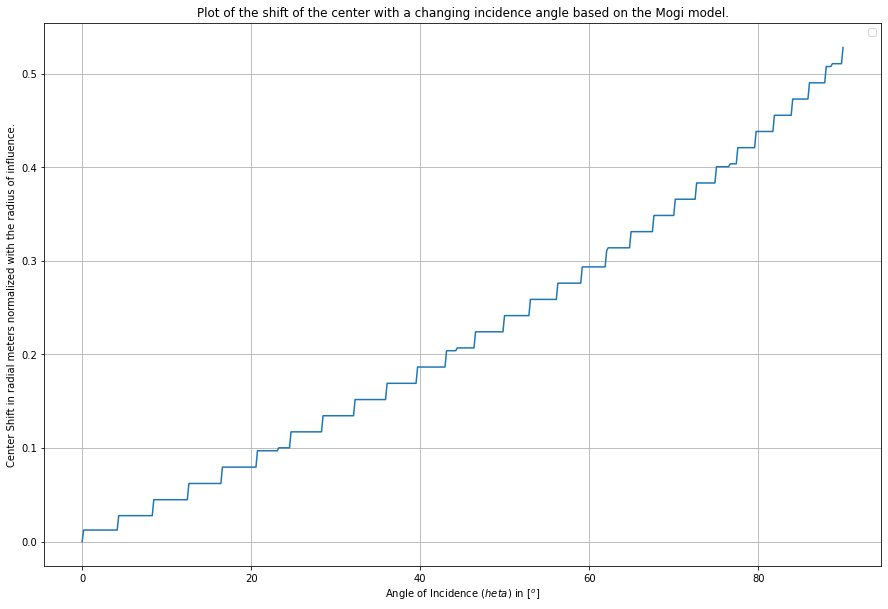

In [35]:
'''
Make plot of the center difference wrt the radius of influence
'''
limit_angle = 35 #[degrees]
R = H/np.tan(np.deg2rad(limit_angle))
mogi_shift_norm = mogi_shift/R

fig,ax = plt.subplots(figsize=(15,10))

ax.plot(los_angle_range,mogi_shift_norm)

ax.set_title('Plot of the shift of the center with a changing incidence angle based on the Mogi model.')
ax.set_ylabel('Center Shift in radial meters normalized with the radius of influence.')
ax.set_xlabel('Angle of Incidence ($\\theta$) in [$^o$]')
ax.legend()
ax.grid(True);

Calculating: 100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


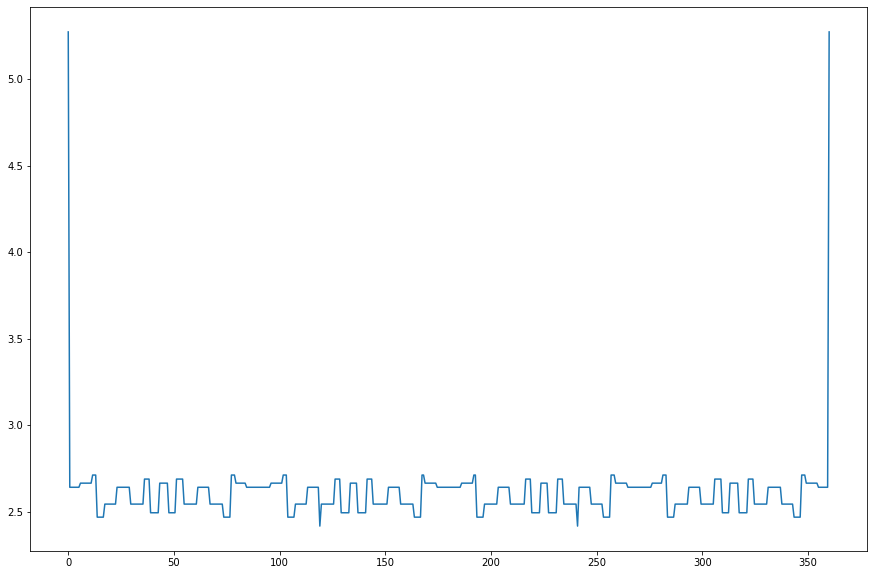

In [39]:
'''
Changing the heading
'''
n = 500
los_angle = 40 #[degrees]

heading_range = np.linspace(0,360,n)
row_idx, col_idx = np.where(zv==np.min(zv))

# x, y position of the mogi model - center
x_mogi = np.sum(xv[row_idx,col_idx])
y_mogi = np.sum(yv[row_idx,col_idx])

mogi_shift_heading = []
for angle in tqdm(heading_range,'Calculating: '):
    z_los = LOS_conversion(de,dn,du,los_angle,angle)
    row_idx_los, col_idx_los = np.where(z_los==np.min(z_los))
    
    # x, y position in the line of sight
    x_los = np.sum(xv[row_idx_los,col_idx_los])
    y_los = np.sum(yv[row_idx_los,col_idx_los])
    
    r = np.sqrt((x_mogi-x_los)**2 + (y_mogi-y_los)**2)
    mogi_shift_heading.append(r)
    
mogi_shift_heading = np.array(mogi_shift_heading)


#plot the results
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(heading_range,mogi_shift_heading)

In [42]:
R

14.281480067421146

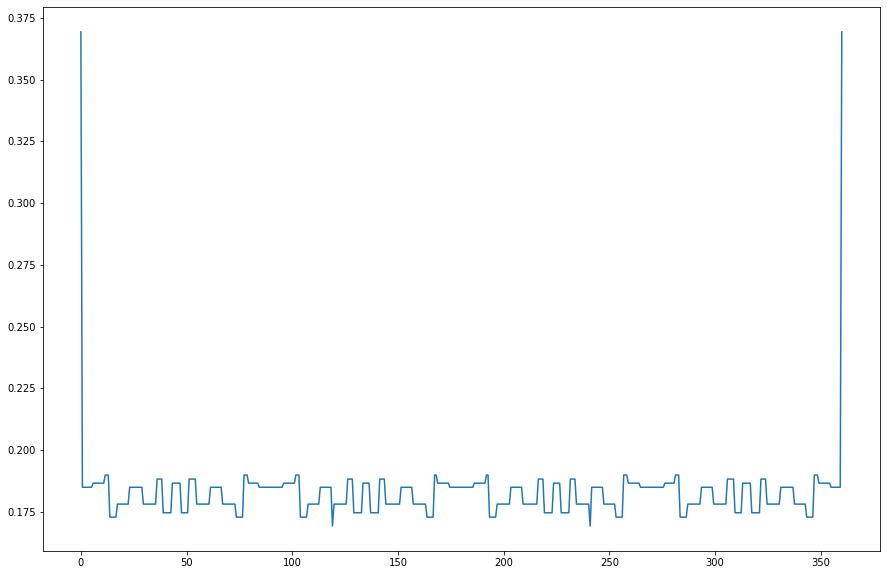

In [41]:
#plot the results
fig,ax = plt.subplots(figsize=(15,10))

ax.plot(heading_range,mogi_shift_heading)